In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
PATH = '../data/' # '/kaggle/input/nfl-big-data-bowl-2020/'
%matplotlib inline

In [4]:
from sklearn.model_selection import TimeSeriesSplit, KFold
import lightgbm as lgb

# Functions and classes

In [5]:
## Model fits on number of yards (as regressor) 
## and predicts proba density for each yard from -99 to 99 (as multiclassifier)

class ConditionalRegressor:
    def __init__(self, model, num_percentiles=10, 
                 kde=KernelDensity(kernel='exponential', metric='manhattan', bandwidth=0.3), 
                 cv_iter=5, 
                 window=0):
        self.model = model
        self.num_percentiles = num_percentiles
        self.kde = kde
        self.cv_iter = cv_iter
        self.window = window
        
    def get_cv_predictions(self, X, y):
        cv = KFold(n_splits=self.cv_iter, shuffle=False)
        y_pred = np.zeros(X.shape[0]) 
        for tr_index, val_index in cv.split(X):
            self.model.fit(X[tr_index], y[tr_index])
            y_pred[val_index] = self.model.predict(X[val_index])
        return y_pred
    
    def bin_predictions(self, pred):
        return np.sum([pred > pct for pct in self.percentiles], axis=0)
    
    def fit(self, X, y):
        ## train regressor on log(y)
        y_log = np.where(y >= 0, np.log(1 + np.abs(y)), -np.log(1 + np.abs(y)))
        pred = self.get_cv_predictions(X, y_log)
        self.model.fit(X, y_log)
        
        ## bin cv predictions
        self.percentiles = np.percentile(pred, np.linspace(1, 99, self.num_percentiles))
        pred_binned = self.bin_predictions(pred)
        
        ## calc distribution for each bin
        self.distribution = {}
        for interval in range(self.num_percentiles + 1):
            filt = [abs(interval - x) <= self.window for x in pred_binned]
            self.kde.fit(y[filt, np.newaxis])
            self.distribution[interval] = np.exp(self.kde.score_samples(np.arange(-99, 100)[:, np.newaxis]))
            self.distribution[interval] /= sum(self.distribution[interval])
    
    def plot_importances(self, column_names, importances=[], h_size=15, v_size=20):
        FI = pd.DataFrame()
        FI["names"] = column_names
        if len(importances) == 0:
            FI["importances"] = self.model.feature_importances_
        else:
            FI["importances"] = importances
        plt.figure(figsize=(h_size, v_size))
        sns.barplot(data=FI.sort_values(by="importances", ascending=False), 
                    x="importances", y="names")
        plt.title("Feature importances")
    
    def predict_proba(self, X):
        pred = self.model.predict(X)
        pred_binned = self.bin_predictions(pred)
        return np.array([self.distribution[x] for x in pred_binned])

In [6]:
def srps_score(y_true, y_pred):
    score = 0
    y_pred_cumsum = np.cumsum(y_pred, axis=1)
    for n in range(199):
         score += ((y_pred_cumsum[:, n] - np.where(n - 99 >= y_true, 1, 0))**2).sum()
    return score/(199 * len(y_true))

In [7]:
def evaluate_model(model, df, features, n_splits=3, print_process=True):
    scores = []
    X_17 = df.loc[df.Season == 2017, features].values
    y_17 = df.loc[df.Season == 2017, 'Yards'].values
    X_18 = df.loc[df.Season == 2018, features].values
    y_18 = df.loc[df.Season == 2018, 'Yards'].values
    cv = TimeSeriesSplit(n_splits=n_splits)
    cnt = 1
    for tr_index, val_index in cv.split(X_18):
        model.fit(np.vstack((X_17, X_18[tr_index])), 
                  np.hstack((y_17, y_18[tr_index])))
        y_pred = model.predict_proba(X_18[val_index])
        score = srps_score(y_18[val_index], y_pred)
        if print_process:
            print("SRPS =", score, " on fold", cnt)
        scores.append(score)
        cnt += 1
    scores = np.array(scores)
    if print_process:
        print("Mean SRPS:", scores.mean())
        print("Std of SRPS:", scores.std())
    return scores

In [8]:
def plot_custom_importances(model, df, features, scores=[], v_size=5):
    ## Calc score with every feature
    if len(scores) == 0:
        scores_with = evaluate_model(model, df, features, print_process=False)
    else:
        scores_with = np.array(scores)
        
    # Calc score without fixed feature
    importances = []
    for col in features:
        other_features = list(features)
        other_features.remove(col)
        scores_without = evaluate_model(model, df, other_features, print_process=False)
        scores_diff = scores_without - scores_with
        importances.append(scores_diff.mean())
        
    # plot importances
    model.plot_importances(features, importances=importances, v_size=v_size)

# Parse data

In [9]:
df = pd.read_csv(PATH + 'train.csv', low_memory=False).select_dtypes(include=np.number)
df_play = df[df.NflId==df.NflIdRusher].reset_index(drop=True)
features = df_play.drop(['GameId', 'PlayId', 'NflIdRusher', 'Yards', 'Down', 'Distance', 'Dir', 'Dis', 
                         'VisitorScoreBeforePlay', 'HomeScoreBeforePlay', 'Humidity', 'Temperature', 
                         'Week', 'Season', 'NflId', 'PlayerWeight', 'JerseyNumber', 'Quarter', 'X', 'Y'], axis=1).select_dtypes(include=np.number).columns.tolist()

# Modelling

## Load evaluation result of previous solution

In [10]:
with open('../data/solution_score.pkl', 'rb') as fout:
    solution_scores = pickle.load(fout)
solution_scores['v0'].mean()

0.013549927333846254

## Evaluate model

In [11]:
X_train = df_play[features].fillna(-999).values
y_train = df_play.Yards.values

In [13]:
lgb_regressor = lgb.LGBMRegressor(n_estimators=30, 
                                  learning_rate=0.1, 
                                  num_leaves=12,
                                  max_depth=5,
                                  colsample_bytree=0.8,
                                  subsample=0.8,
                                  reg_alpha=0.5,
                                  reg_lambda=0.5,
                                  random_state=228)
cond_regressor = ConditionalRegressor(lgb_regressor)

In [14]:
scores = evaluate_model(cond_regressor, df_play, features, 
                        n_splits=5)

SRPS = 0.014897033817097166  on fold 1
SRPS = 0.0142716257612068  on fold 2
SRPS = 0.014808078518659328  on fold 3
SRPS = 0.01481761021276904  on fold 4
SRPS = 0.014088704190596518  on fold 5
Mean SRPS: 0.01457661050006577
Std of SRPS: 0.0003302719076787696


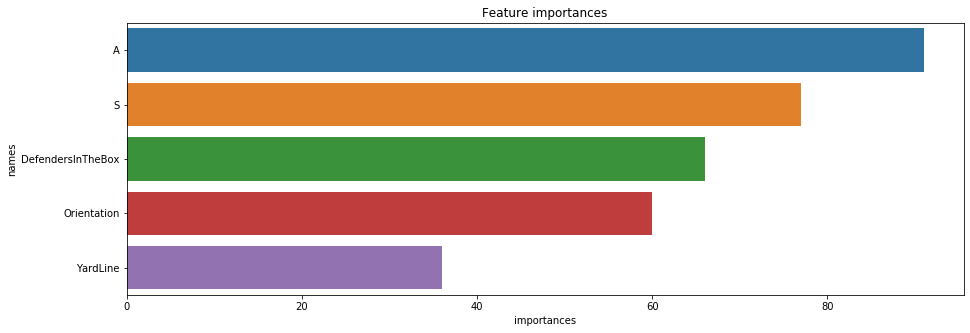

In [15]:
cond_regressor.plot_importances(features, v_size=5)

CPU times: user 13.7 s, sys: 68.3 ms, total: 13.8 s
Wall time: 5.99 s


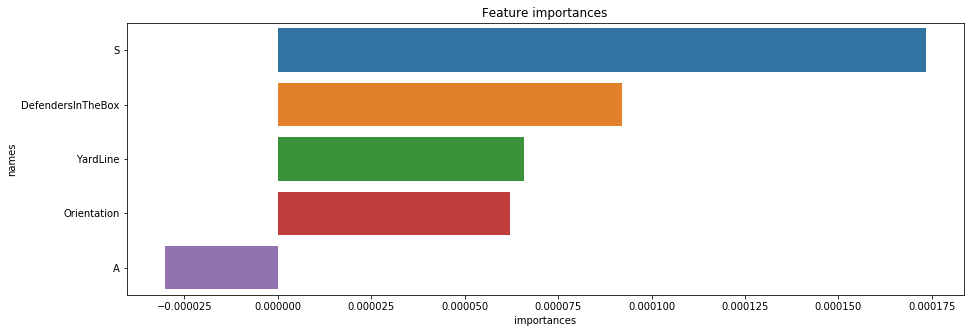

In [16]:
%%time
plot_custom_importances(cond_regressor, df_play, features, v_size=5)

## Save evaluation result

In [92]:
solution_scores = {}
solution_scores['v0'] = scores
with open('../data/solution_score.pkl', 'wb') as fout:
    pickle.dump(solution_scores, fout, protocol=pickle.HIGHEST_PROTOCOL)

## Fit model

In [341]:
%%time
cond_regressor.fit(X_train, y_train)

CPU times: user 3.54 s, sys: 24.1 ms, total: 3.56 s
Wall time: 1.06 s


# Predict on test

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()
columns = ['Yards' + str(i) for i in range(-99, 100)]

for df_test, _ in env.iter_test():
    X_test = df_test.loc[df_test.NflId == df_test.NflIdRusher, 
                         features].reset_index(drop=True).fillna(-999).values
    y_pred = np.clip(np.cumsum(cond_regressor.predict_proba(X_test), axis=1), 0, 1)
    env.predict(pd.DataFrame(y_pred, columns=columns))
env.write_submission_file()